## Looking at rate of change..

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import common

In [11]:
df = common.load_df("../data/insead", "*.csv")
print(common.load_df.cache_info())

# step 1: Let's smooth the data.
df = df.rolling(10, min_periods=1).mean()

# step 2: take train and test data.. 
train = df["2016-01-01":"2016-01-15"].copy()
test = df["2016-01-16":"2016-01-16"].copy()

CacheInfo(hits=1, misses=1, maxsize=None, currsize=1)


In [12]:
def plot_with_min_max(tr, te, ref):
    # step 3: add necessary variables.
    tr["hour"] = tr.index.hour
    te["hour"] = te.index.hour

    # step 4: assuming 1hr bins. group data.
    min_per_hr = tr.groupby(["hour"]).quantile(.1)
    max_per_hr = tr.groupby(["hour"]).quantile(.9)
    
    # step 5: set columns with bin values. eg: At column corresponding to hr 3, add min & min possible values.. at that hr.
    get_bin_val = lambda x, bins, field: bins[field].iloc[int(x.hour)]
    te["cwshdr_min"] = te.apply(get_bin_val, axis=1, args=(min_per_hr, "cwshdr"))
    te["cwshdr_max"] = te.apply(get_bin_val, axis=1, args=(max_per_hr, "cwshdr"))
    
    # plot.
    fig, ax = plt.subplots(1,1,figsize=(36,6))
    
    # make copies..
    te = te.copy()
    ref = ref.copy()
    
    # norm
    ref.cwshdr -= ref.cwshdr.min()
    ref.cwshdr /= (ref.cwshdr.max() - ref.cwshdr.min())
    
    # plot all together.
    te["cwshdr_ref"] = ref.cwshdr
    te[["cwshdr", "cwshdr_min", "cwshdr_max", "cwshdr_ref"]].plot(ax=ax)
    # ref[["cwshdr"]].plot(ax=ax[1])
    return ax

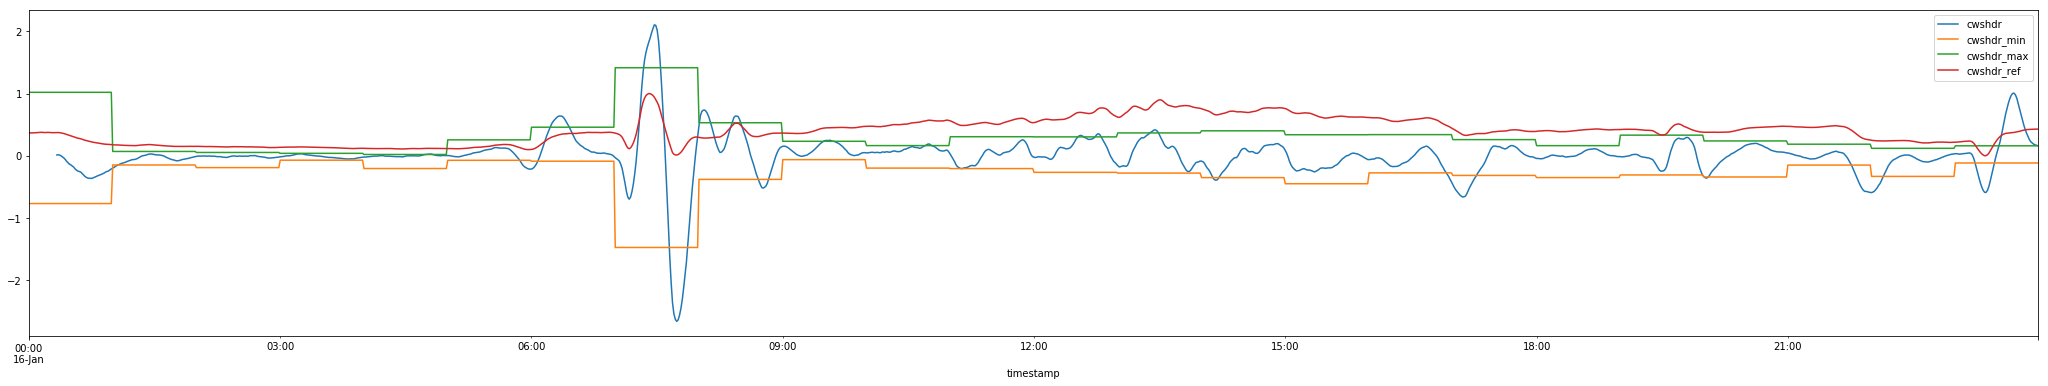

In [14]:
# rate of change. x(t+k) - x(t). k determines sensitivity.
tr_dff = train - train.shift(20)
te_dff = test - test.shift(20)
ax = plot_with_min_max(tr_dff, te_dff, test)

Again, the hypothesis isn't solid... huuhhhh!!!!